# coproID report

In [13]:
import datetime
with open("version.txt", "r") as f:
    for line in f:
        print(f"Version {line.rstrip()}")
print(f"Report generated on {datetime.datetime.now()}")

Version 0.6.2
Report generated on 2019-02-22 18:32:18.299401


## Introduction
[coproID](https://github.com/maxibor/coproID) is a pipeline to identify the source of coprolites, and in general, of a metagenomic sample.

If you read these lines, coproID successfully finished running and you can find your results below.

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.transform import factor_cmap
from bokeh.palettes import Set1
from bokeh.models.tools import HoverTool
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Button
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn
from bokeh.models import CustomJS

In [6]:
def plot_bokeh(df):
    d = pd.read_csv(df, index_col = 0)
    TOOLS="pan,wheel_zoom,zoom_in,zoom_out,box_zoom,reset,save"
    source = ColumnDataSource(d)
    labels = list(set(source.data['label']))
    color_map = factor_cmap(field_name='label', palette=Set1[9], factors=labels)
    p = figure(tools=TOOLS)
    p.scatter(x = 'PC1', y='PC2', color=color_map, alpha = 0.6, size = 6, source=d)
    hover = HoverTool()
    hover.tooltips = [("Organism", "@label"),('Sample',"@name")]
    p.add_tools(hover)
    output_notebook(hide_banner=True)
    show(p)

In [17]:
def bokeh_table(df):
    
    d = pd.read_csv(df, index_col = 0)
    source = ColumnDataSource(d)

    Columns = [TableColumn(field=Ci, title=Ci) for Ci in d.columns] # bokeh columns
    data_table = DataTable(columns=Columns, source=ColumnDataSource(d)) # bokeh table

    button = Button(label="Download", button_type="success")

    javaScript="""
        function table_to_csv(source) {
        const columns = Object.keys(source.data)
        const nrows = source.get_length()
        const lines = [columns.join(',')]

        for (let i = 0; i < nrows; i++) {
            let row = [];
            for (let j = 0; j < columns.length; j++) {
                const column = columns[j]
                row.push(source.data[column][i].toString())
            }
            lines.push(row.join(','))
        }
        return lines.join('\\n').concat('\\n')
    }


    const filename = 'coproID_result.csv'
    filetext = table_to_csv(source)
    const blob = new Blob([filetext], { type: 'text/csv;charset=utf-8;' })

    //addresses IE
    if (navigator.msSaveBlob) {
        navigator.msSaveBlob(blob, filename)
    } else {
        const link = document.createElement('a')
        link.href = URL.createObjectURL(blob)
        link.download = filename
        link.target = '_blank'
        link.style.visibility = 'hidden'
        link.dispatchEvent(new MouseEvent('click'))
    }
    """
    button.callback = CustomJS(args=dict(source=source),code=javaScript)
    output_notebook(hide_banner=True)
    show(button)

In [9]:
umap = "embedding.umap.csv"

## 1- coproID summary table

In [27]:
d = "coproID_result.csv"
pd.read_csv(d, index_col = 0)

,normalized_bp_proportion_aligned_Bacillus_subtilis,normalized_bp_proportion_aligned_Escherichia_coli,metagenomic_proportion_Bacillus_subtilis,metagenomic_proportion_Escherichia_coli,coproID_proba_Bacillus_subtilis,coproID_proba_Escherichia_coli
metagenomebis,0.001471,0.998529,0.0,1.0,0.000000,0.998529
metagenome,0.994666,0.005334,1.0,0.0,0.994666,0.000000


In [26]:
bokeh_table(d)

## 2- microbiome profile embedding

In [12]:
plot_bokeh(umap)

## 3- Damage plots

In [52]:

allplots = os.listdir(".")
allplots = [i for i in allplots if "_freq.txt" in i]
fwd_ext = ".5pCtoT_freq.txt"
rev_ext = ".3pGtoA_freq.txt"
samples = list(set([i.split("_")[0] for i in allplots]))
species = list(set(["_".join(i.split(".")[0].split("_")[1:]) for i in allplots]))

In [57]:
def plot_damage(fwd, rev, sample, organism):
    f = pd.read_csv(fwd, skiprows=3, delimiter="\t")
    r =  pd.read_csv(rev, skiprows=3, delimiter="\t")
    r['pos'] = list(r['pos']*-1)[::-1]
    fig = plt.figure(figsize=(18,3))
    fig.suptitle(f"Sample: {sample} - Species: {organism}", fontsize="x-large", y = 1.2)
    plt.title('Test')
    plt.subplot(1, 2, 1)
    plt.plot(f['pos'],f['5pC>T'])
    plt.title('5pC>T')
    plt.ylabel('Frequency')
    plt.xticks(f['pos'])

    plt.subplot(1, 2, 2)
    plt.plot(r['pos'][::-1],r['3pG>A'], color = 'red')
    plt.title('3pG>A')
    plt.ylabel('Frequency')
    plt.xticks(r['pos'])

Sample: metagenome
Sample: metagenomebis


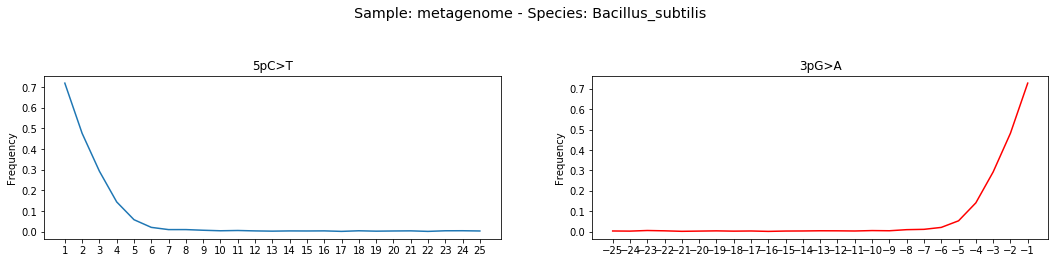

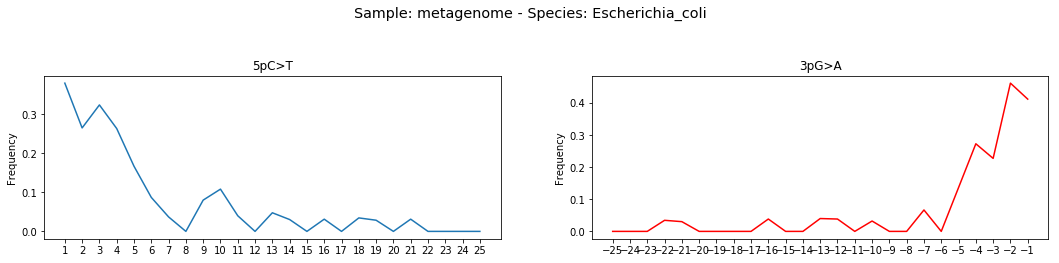

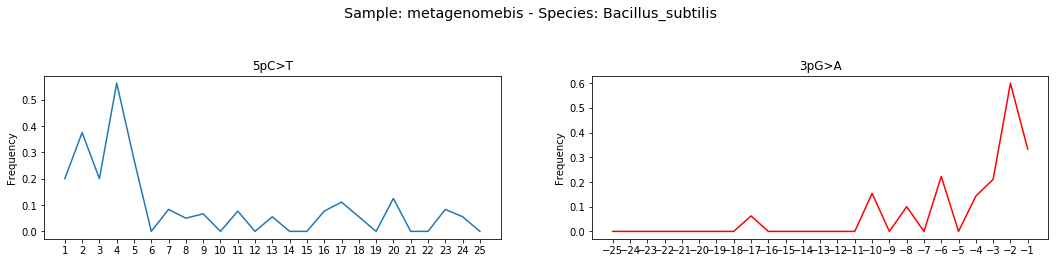

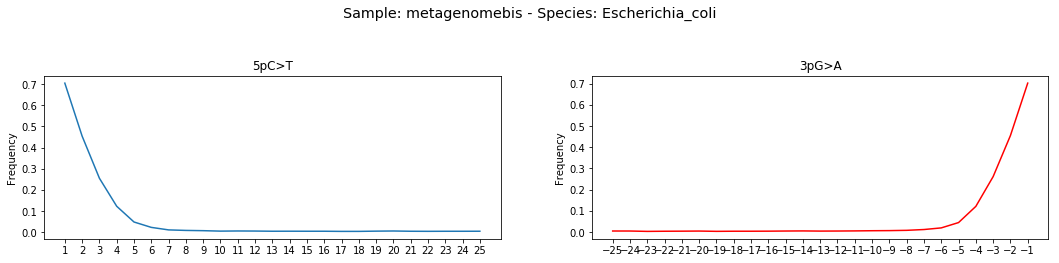

In [58]:
for sa in samples:
    for sp in species:
        plot_damage(f"{sa}_{sp}{fwd_ext}", f"{sa}_{sp}{rev_ext}", sa, sp)